The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>


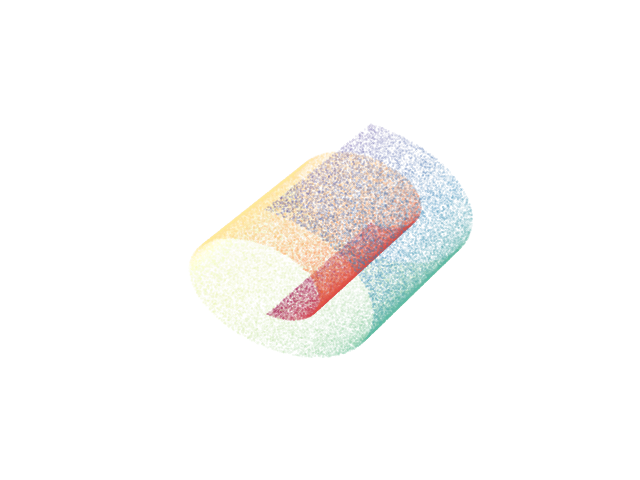

<IPython.core.display.Javascript object>


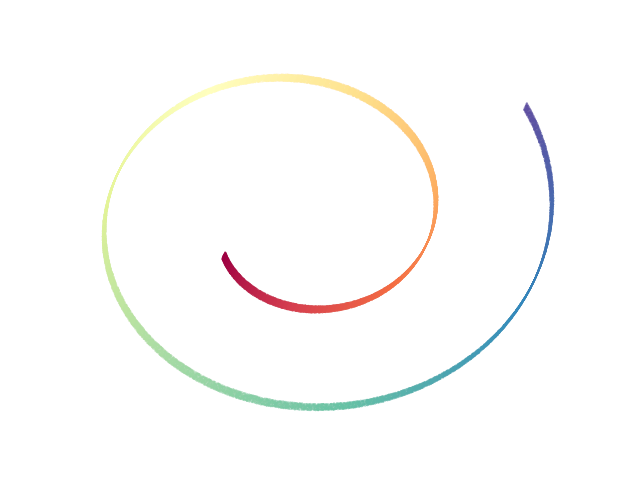

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
from scipy import optimize

from sklearn.datasets import make_swiss_roll as swiss

from sklearn.decomposition import PCA

from scipy.spatial import procrustes
from matplotlib.colors import ListedColormap

%matplotlib notebook

%load_ext autoreload
%autoreload 2

#sklearn.datasets.make_swiss_roll(n_samples=100, *, noise=0.0, random_state=None)


X_train, y_train = swiss(n_samples=60000, random_state=79477)

n_components = 2

pca0 = PCA(n_components = n_components)
x_train_nc = pca0.fit_transform(X_train)

n = len(X_train)


fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(X_train[:,0], X_train[:,1], X_train[:,2], c=y_train, s=0.01, cmap='Spectral')
ax.axis('off')
plt.savefig('sr_figures/swiss_roll.png', dpi=fig.dpi)

plt.figure()
plt.scatter(x_train_nc[:,0], x_train_nc[:,1], c=y_train, s=0.01, cmap='Spectral')
plt.axis('off')
plt.savefig('sr_figures/swiss_roll_pca.png', dpi=fig.dpi)


#set_up_parameters


epochs = 200
n_neighbors= 30
n_components = 2
MIN_DIST = 0.1
    


In [4]:
import numba
from numba import prange

#@numba.jit(nopython=True)
def map_rotate(y, rot_angle):
    theta = (rot_angle) * np.pi / 180
    rot_mat = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])

    Y = y
    Y = rot_mat.dot(Y.T).T
    
    return Y

@numba.jit(nopython=True, parallel=True)
def get_first_order_graph(X,n_neighbors):
    
    N = X.shape[0]
    
    dist = np.zeros((N, N), dtype=np.float32)

    sort_idx = np.zeros((N,n_neighbors), dtype=np.int32)
    
    for i in range(N):
        if (i+1)%10000 == 0:
            print('Completed ', i+1, ' of ', N)
        
        for j in prange(i+1,N):
            dist[i,j] = np.sum( (X[i]-X[j])**2 )
            dist[j,i] = dist[i,j]
        
        sort_idx[i,:] = np.argsort(dist[i,:])[1:n_neighbors+1]
    
    return sort_idx, dist

@numba.jit(nopython=True, parallel=True)
def my_trustworthiness(Y,sort_idx,K):
    N = Y.shape[0]

    val = 0.0
    for i in prange(N):
        dist = np.sum((Y - Y[i,:])**2,axis=1)
        
        sort_idy = np.argsort(dist)[1:]
        for j in prange(K):
            r_0 = np.argwhere(sort_idy[j]==sort_idx[i,:])
            #print(i, r_0, sort_idx[i,j])
            #print(sort_idy)
            r = r_0[0,0] 
            #print(i,r)
            #print(sort_idx[i,j])
            #print(sort_idy)
            r_v = r - K + 1
            if r_v>0:
                val += r_v
        #print(val)
    #print(val)
    val = val * 2.0 / ( N*K * (2*N - 3*K - 1.0))
    
    #print(val)
    
    return 1 - val


In [32]:
np.random.seed(23423)

rand_perm = np.random.permutation(n)

X_train_rp = X_train[rand_perm]
y_train_rp = y_train[rand_perm]

nA = 10000
nB = 25000
nC = 25000

SETA = X_train_rp[:nA]
y_SETA = y_train_rp[:nA]
SETB = X_train_rp[nA:nA+nB]
y_SETB = y_train_rp[nA:nA+nB]
SETC = X_train_rp[nA+nB:nA+nB+nC]
y_SETC = y_train_rp[nA+nB:nA+nB+nC]

data1 = np.concatenate((SETA, SETB))
data2 = np.concatenate((SETA, SETC))


print(SETA.shape, SETB.shape, SETC.shape)

(10000, 3) (25000, 3) (25000, 3)


In [6]:
Com_set = np.concatenate((SETA,SETB,SETC))
y_com_set = np.concatenate((y_SETA, y_SETB, y_SETC))

sort_idx, dist = get_first_order_graph(Com_set,n_neighbors=Com_set.shape[0]-1)

/home/ponir/pyTorch1.9/lib/python3.6/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


Completed  10000  of  60000
Completed  20000  of  60000
Completed  30000  of  60000
Completed  40000  of  60000
Completed  50000  of  60000
Completed  60000  of  60000


In [29]:
with open('SR_Aligned_NE.npy', 'rb') as f:
    embA_ne = np.load(f)
    embB_ne = np.load(f)
    embC_ne = np.load(f)

In [30]:
k_nn=5
T1_ne = my_trustworthiness(np.concatenate((embA_ne,embB_ne,embC_ne)),sort_idx,k_nn)

print(T1_ne)

0.9978357687691692


<IPython.core.display.Javascript object>


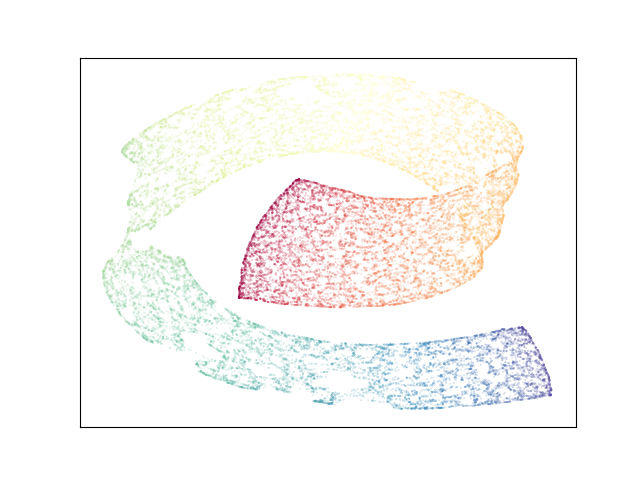

<IPython.core.display.Javascript object>


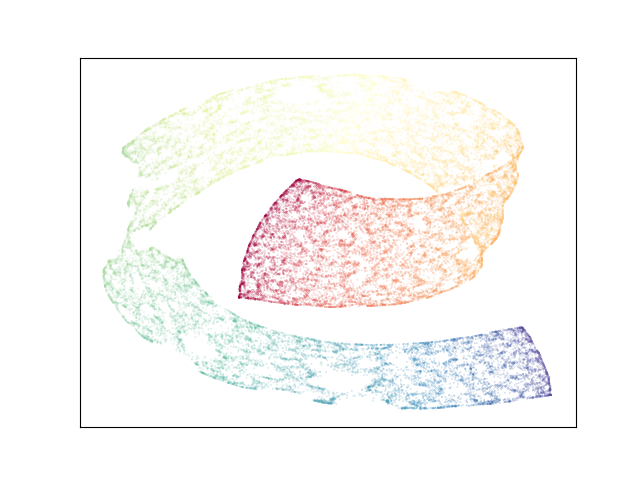

In [38]:
emb_set1 = np.concatenate((embA_ne, embB_ne))
emb_set1 = map_rotate(emb_set1, rot_angle=40)
y_emb_set1 = np.concatenate((y_SETA, y_SETB))

embA_rot = embA_ne #map_rotate(embA_ne, rot_angle=40)

fig = plt.figure()
#plt.title('EM_SET_1')
plt.scatter(emb_set1[:,0], -emb_set1[:,1], c=y_emb_set1, s=0.01, cmap='Spectral')

#plt.scatter(embA_rot[:,0], -embA_rot[:,1], c='k', s=1)
plt.xticks([],[])
plt.yticks([],[])

plt.xlim([-12.7, 11.5])
plt.ylim([-14.5, 14.0])

#cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
#cbar.set_ticks(np.arange(10))
#cbar.set_ticklabels(classes)

plt.savefig('sr_figures/ne10k_umap_1.png', dpi=fig.dpi, bbox_inches='tight')

emb_set2 = np.concatenate((embA_ne, embC_ne))
emb_set2 = map_rotate(emb_set2, rot_angle=40)
y_emb_set2 = np.concatenate((y_SETA,y_SETC))


plt.figure()
#plt.title('EM_SET_2')
plt.scatter(emb_set2[:,0], -emb_set2[:,1], c=y_emb_set2, s=0.01, cmap='Spectral')

#plt.scatter(embA_rot[:,0], -embA_rot[:,1], c='k', s=1)
plt.xticks([],[])
plt.yticks([],[])

plt.xlim([-12.7, 11.5])
plt.ylim([-14.5, 14.0])

#cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
#cbar.set_ticks(np.arange(10))
#cbar.set_ticklabels(classes)

plt.savefig('sr_figures/ne10k_umap_2.png', dpi=fig.dpi, bbox_inches='tight')

In [10]:
#np.random.seed(23423)

#rand_perm = np.random.permutation(n)

#X_train_rp = X_train[rand_perm]
#y_train_rp = y_train[rand_perm]

nA = 5000
nB = 27500
nC = 27500

#SETA = X_train_rp[:nA]
y_SETA_ne5 = y_train_rp[:nA]
#SETB = X_train_rp[nA:nA+nB]
y_SETB_ne5 = y_train_rp[nA:nA+nB]
#SETC = X_train_rp[nA+nB:nA+nB+nC]
y_SETC_ne5 = y_train_rp[nA+nB:nA+nB+nC]

#data1 = np.concatenate((SETA, SETB))
#data2 = np.concatenate((SETA, SETC))


#print(SETA.shape, SETB.shape, SETC.shape)


with open('SR_Aligned_NE_5_27.5_27.5.npy', 'rb') as f:
    embA_ne5 = np.load(f)
    embB_ne5 = np.load(f)
    embC_ne5 = np.load(f)

In [11]:
T1_ne5 = my_trustworthiness(np.concatenate((embA_ne5,embB_ne5,embC_ne5)),sort_idx,k_nn)

print(T1_ne5)

0.9978377452549229


<IPython.core.display.Javascript object>


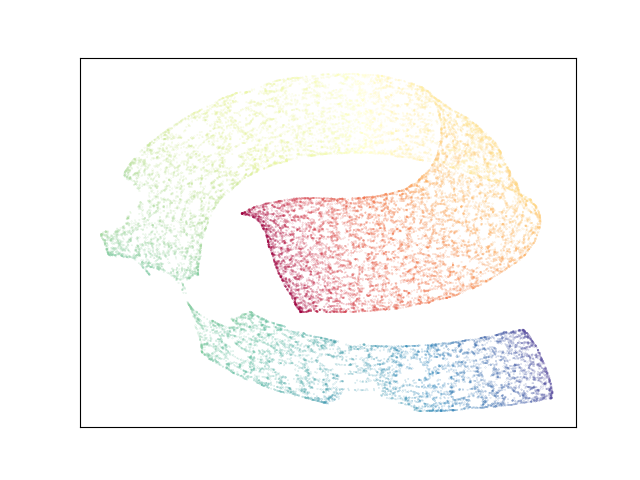

<IPython.core.display.Javascript object>


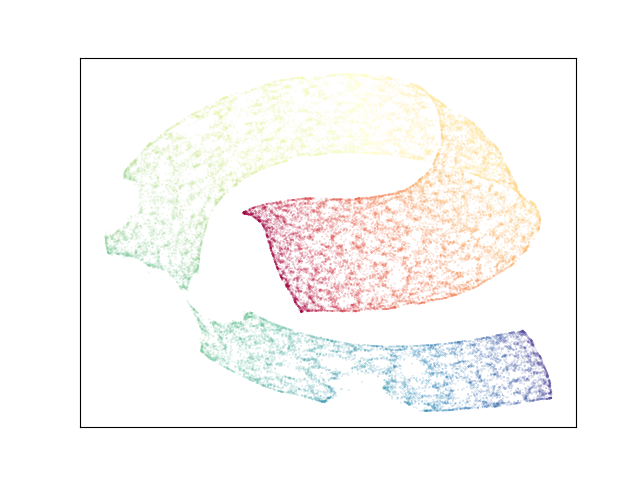

<IPython.core.display.Javascript object>


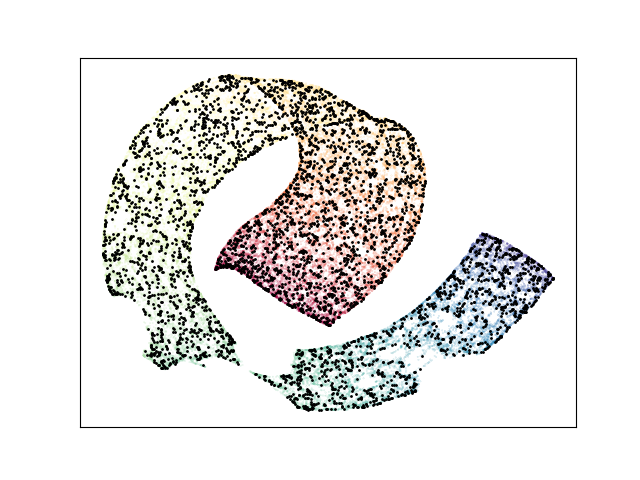

([], [])

In [37]:
emb_set1 = np.concatenate((embA_ne5, embB_ne5))
emb_set1 = map_rotate(emb_set1, rot_angle=40)
y_emb_set1 = np.concatenate((y_SETA_ne5, y_SETB_ne5))

embA_rot5 = embA_ne5 



plt.figure()
plt.scatter(emb_set1[:,0], -emb_set1[:,1], c=y_emb_set1, s=0.01, cmap='Spectral')
plt.xticks([],[])
plt.yticks([],[])

plt.xlim([-13.8, 11.4])
plt.ylim([-14.3, 13.6])

plt.savefig('sr_figures/ne5k_umap_1.png', dpi=fig.dpi, bbox_inches='tight')

emb_set2 = np.concatenate((embA_ne5, embC_ne5))
emb_set2 = map_rotate(emb_set2, rot_angle=40)
y_emb_set2 = np.concatenate((y_SETA_ne5,y_SETC_ne5))


plt.figure()
plt.scatter(emb_set2[:,0], -emb_set2[:,1], c=y_emb_set2, s=0.01, cmap='Spectral')
plt.xticks([],[])
plt.yticks([],[])

plt.xlim([-13.8, 11.4])
plt.ylim([-14.3, 13.6])


plt.savefig('sr_figures/ne5k_umap_2.png', dpi=fig.dpi, bbox_inches='tight')

emb_set = np.concatenate((embA_ne5, embB_ne5, embC_ne5))
y_emb_set = np.concatenate((y_SETA_ne5, y_SETB_ne5, y_SETC_ne5))

plt.figure()
#plt.title('EM_SET_2')
plt.scatter(emb_set[:,0], -emb_set[:,1], c=y_emb_set, s=0.01, cmap='Spectral')
plt.scatter(embA_rot5[:,0], -embA_rot5[:,1], c='k', s=1)
plt.xticks([],[])
plt.yticks([],[])

In [13]:
nA = 1000
nB = 29500
nC = 29500


y_SETA_ne1 = y_train_rp[:nA]

y_SETB_ne1 = y_train_rp[nA:nA+nB]

y_SETC_ne1 = y_train_rp[nA+nB:nA+nB+nC]


with open('SR_Aligned_NE_1_29.5_29.5.npy', 'rb') as f:
    embA_ne1 = np.load(f)
    embB_ne1 = np.load(f)
    embC_ne1 = np.load(f)

In [14]:
T1_ne1 = my_trustworthiness(np.concatenate((embA_ne1,embB_ne1,embC_ne1)),sort_idx,k_nn)

print(T1_ne1)

0.9952745014890875


<IPython.core.display.Javascript object>


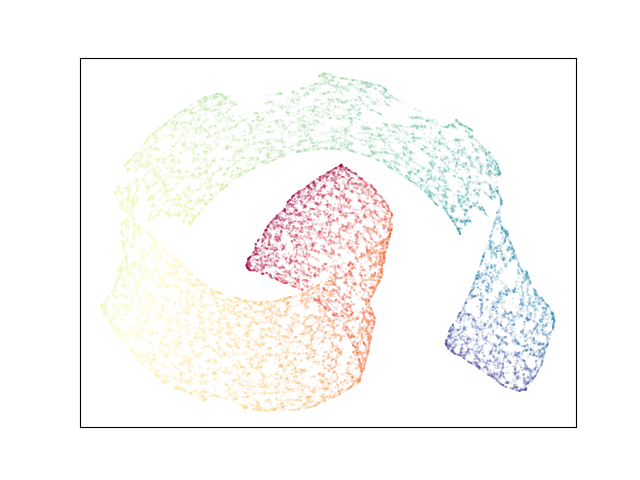

<IPython.core.display.Javascript object>


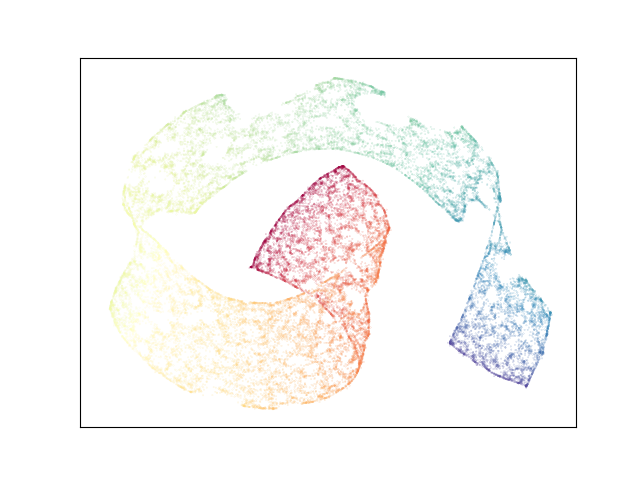

<IPython.core.display.Javascript object>


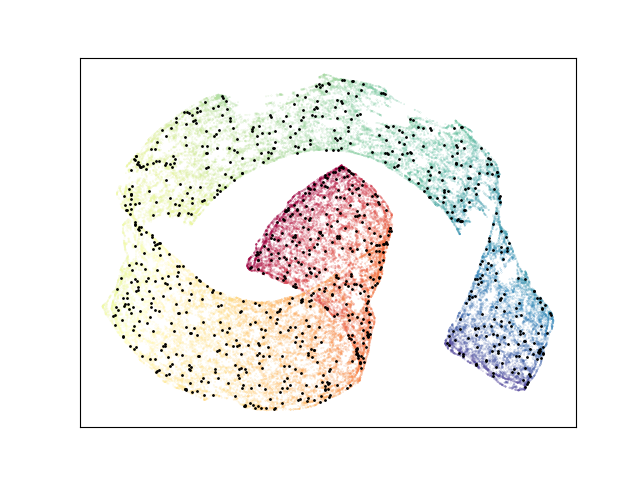

([], [])

In [40]:
emb_set1 = np.concatenate((embA_ne1, embB_ne1))
emb_set1 = map_rotate(emb_set1, rot_angle=40)
y_emb_set1 = np.concatenate((y_SETA_ne1, y_SETB_ne1))

embA_rot1 = map_rotate(embA_ne1, rot_angle=40)

plt.figure()
plt.scatter(emb_set1[:,0], -emb_set1[:,1], c=y_emb_set1, s=0.01, cmap='Spectral')
plt.xticks([],[])
plt.yticks([],[])

plt.xlim([-13,14.5])
plt.ylim([-11.8,13.4])


plt.savefig('sr_figures/ne1k_umap_1.png', dpi=fig.dpi, bbox_inches='tight')

emb_set2 = np.concatenate((embA_ne1, embC_ne1))
emb_set2 = map_rotate(emb_set2, rot_angle=40)
y_emb_set2 = np.concatenate((y_SETA_ne1,y_SETC_ne1))


plt.figure()
plt.scatter(emb_set2[:,0], -emb_set2[:,1], c=y_emb_set2, s=0.01, cmap='Spectral')
plt.xticks([],[])
plt.yticks([],[])

plt.xlim([-13,14.5])
plt.ylim([-11.8,13.4])

plt.savefig('sr_figures/ne1k_umap_2.png', dpi=fig.dpi, bbox_inches='tight')

emb_set = np.concatenate((embA_ne1, embB_ne1, embC_ne1))
emb_set = map_rotate(emb_set, rot_angle=40)
y_emb_set = np.concatenate((y_SETA_ne1, y_SETB_ne1, y_SETC_ne1))

plt.figure()
plt.scatter(emb_set[:,0], -emb_set[:,1], c=y_emb_set, s=0.01, cmap='Spectral')
plt.scatter(embA_rot1[:,0], -embA_rot1[:,1], c='k', s=1)
plt.xticks([],[])
plt.yticks([],[])

In [16]:
nA = 100
nB = 29950
nC = 29950

y_SETA_ne100 = y_train_rp[:nA]
y_SETB_ne100 = y_train_rp[nA:nA+nB]
y_SETC_ne100 = y_train_rp[nA+nB:nA+nB+nC]

with open('SR_Aligned_NE_0.1_29.95_29.95.npy', 'rb') as f:
    embA_ne100 = np.load(f)
    embB_ne100 = np.load(f)
    embC_ne100 = np.load(f)

In [17]:
T1_ne100 = my_trustworthiness(np.concatenate((embA_ne100,embB_ne100,embC_ne100)),sort_idx,k_nn)

print(T1_ne100)

0.9943586917144508


<IPython.core.display.Javascript object>


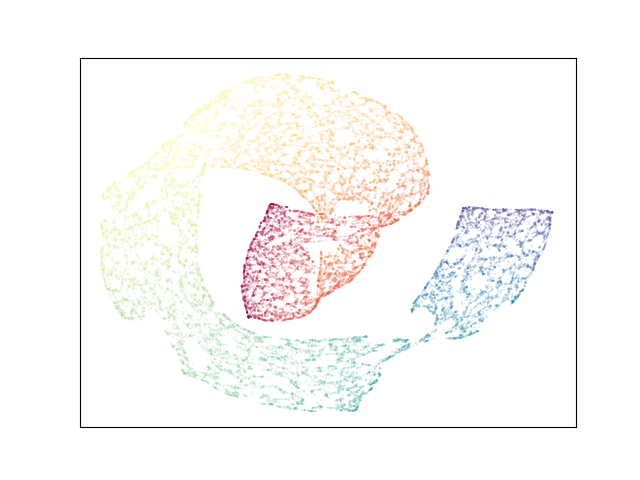

<IPython.core.display.Javascript object>


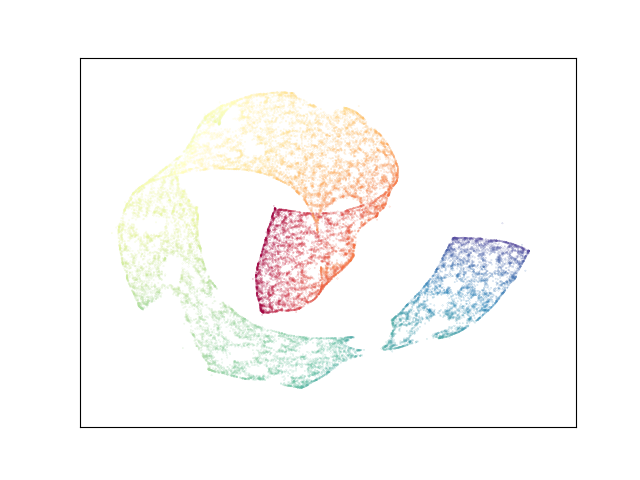

<IPython.core.display.Javascript object>


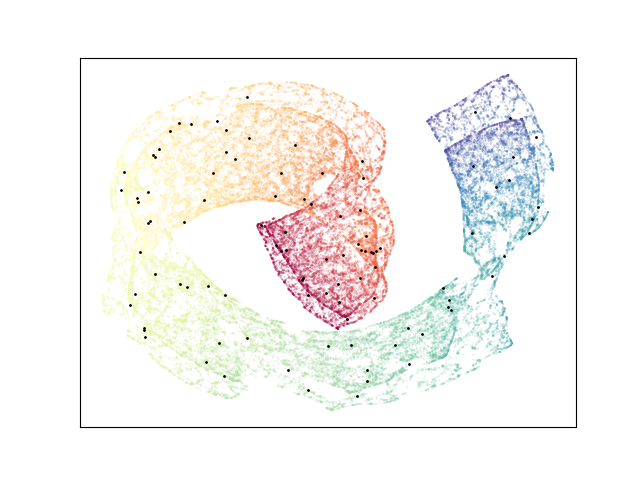

([], [])

In [42]:
emb_set1 = np.concatenate((embA_ne100, embB_ne100))
emb_set1 = map_rotate(emb_set1, rot_angle=40)
y_emb_set1 = np.concatenate((y_SETA_ne100, y_SETB_ne100))

embA_rot100 = embA_ne100 #map_rotate(embA_ne100, rot_angle=40)

plt.figure()
plt.scatter(emb_set1[:,0], -emb_set1[:,1], c=y_emb_set1, s=0.01, cmap='Spectral')
plt.xticks([],[])
plt.yticks([],[])

plt.xlim([-13.4,17.8])
plt.ylim([-14.2,14])

plt.savefig('sr_figures/ne100_umap_1.png', dpi=fig.dpi, bbox_inches='tight')

emb_set2 = np.concatenate((embA_ne100, embC_ne100))
emb_set2 = map_rotate(emb_set2, rot_angle=40)
y_emb_set2 = np.concatenate((y_SETA_ne100, y_SETC_ne100))


plt.figure()
plt.scatter(emb_set2[:,0], -emb_set2[:,1], c=y_emb_set2, s=0.01, cmap='Spectral')
plt.xticks([],[])
plt.yticks([],[])

plt.xlim([-13.4,17.8])
plt.ylim([-14.2,14])

plt.savefig('sr_figures/ne100_umap_2.png', dpi=fig.dpi, bbox_inches='tight')

emb_set = np.concatenate((embA_ne100, embB_ne100, embC_ne100))
y_emb_set = np.concatenate((y_SETA_ne100, y_SETB_ne100, y_SETC_ne100))

plt.figure()
plt.scatter(emb_set[:,0], -emb_set[:,1], c=y_emb_set, s=0.01, cmap='Spectral')

plt.scatter(embA_rot100[:,0], -embA_rot100[:,1], c='k', s=1)
plt.xticks([],[])
plt.yticks([],[])


In [19]:
nA = 20000
nB = 20000
nC = 20000

y_SETA_ne20 = y_train_rp[:nA]
y_SETB_ne20 = y_train_rp[nA:nA+nB]
y_SETC_ne20 = y_train_rp[nA+nB:nA+nB+nC]

with open('SR_Aligned_NE_20_20_20.npy', 'rb') as f:
    embA_ne20 = np.load(f)
    embB_ne20 = np.load(f)
    embC_ne20 = np.load(f)

In [20]:
T1_ne100 = my_trustworthiness(np.concatenate((embA_ne20,embB_ne20,embC_ne20)),sort_idx,k_nn)

print(T1_ne100)

0.9950077271413966


<IPython.core.display.Javascript object>


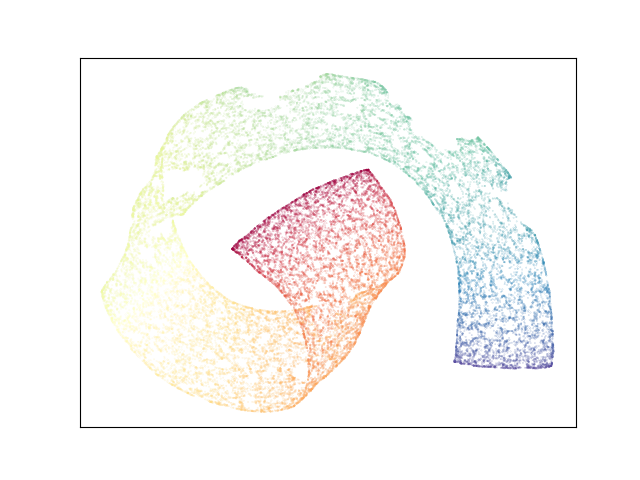

<IPython.core.display.Javascript object>


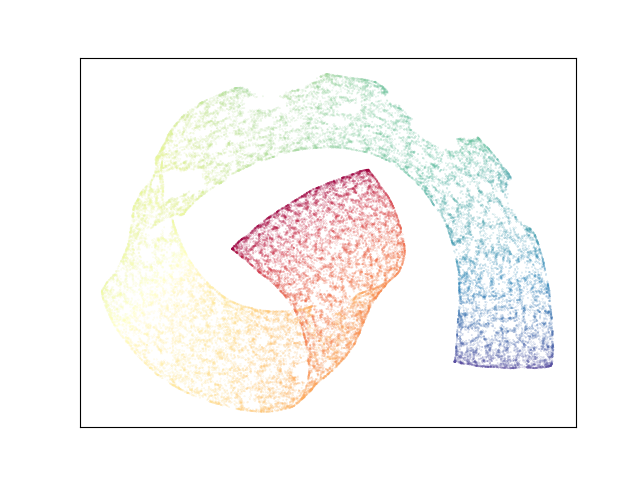

<IPython.core.display.Javascript object>


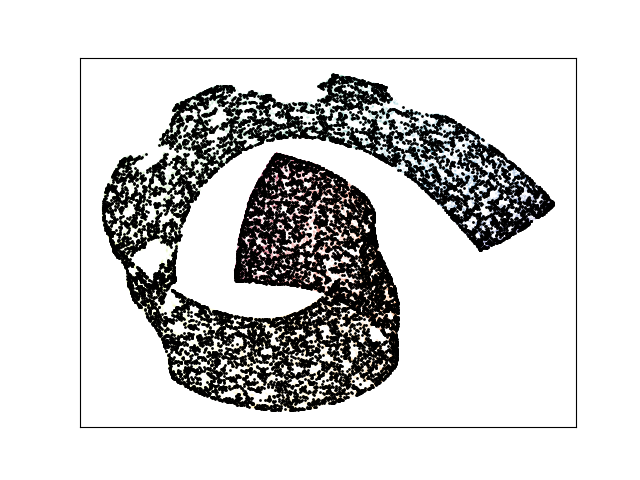

([], [])

In [44]:
emb_set1 = np.concatenate((embA_ne20, embB_ne20))
emb_set1 = map_rotate(emb_set1, rot_angle=40)
y_emb_set1 = np.concatenate((y_SETA_ne20, y_SETB_ne20))

embA_rot20 = embA_ne20 

plt.figure()
plt.scatter(emb_set1[:,0], -emb_set1[:,1], c=y_emb_set1, s=0.01, cmap='Spectral')
plt.xticks([],[])
plt.yticks([],[])

plt.xlim([-14.2, 15.4])
plt.ylim([-12.5, 14.1])

plt.savefig('sr_figures/ne20k_umap_1.png', dpi=fig.dpi, bbox_inches='tight')

emb_set2 = np.concatenate((embA_ne20, embC_ne20))
emb_set2 = map_rotate(emb_set2, rot_angle=40)
y_emb_set2 = np.concatenate((y_SETA_ne20, y_SETC_ne20))


plt.figure()
plt.scatter(emb_set2[:,0], -emb_set2[:,1], c=y_emb_set2, s=0.01, cmap='Spectral')
plt.xticks([],[])
plt.yticks([],[])

plt.xlim([-14.2, 15.4])
plt.ylim([-12.5, 14.1])

plt.savefig('sr_figures/ne20k_umap_2.png', dpi=fig.dpi, bbox_inches='tight')

emb_set = np.concatenate((embA_ne20, embB_ne20, embC_ne20))

y_emb_set = np.concatenate((y_SETA_ne20, y_SETB_ne20, y_SETC_ne20))

plt.figure()
plt.scatter(emb_set[:,0], -emb_set[:,1], c=y_emb_set, s=0.01, cmap='Spectral')

plt.scatter(embA_rot20[:,0], -embA_rot20[:,1], c='k', s=1)
plt.xticks([],[])
plt.yticks([],[])


in loop
in loop
in loop
in loop
in loop
out of loop
(3000, 3) (5, 11400, 3) (11400, 3) (5, 14400, 3) 5
Completed  10000  of  14400


<IPython.core.display.Javascript object>


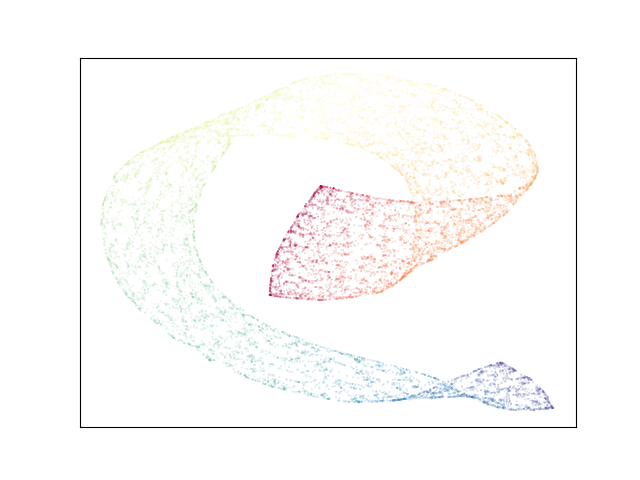

Completed  10000  of  14400


<IPython.core.display.Javascript object>


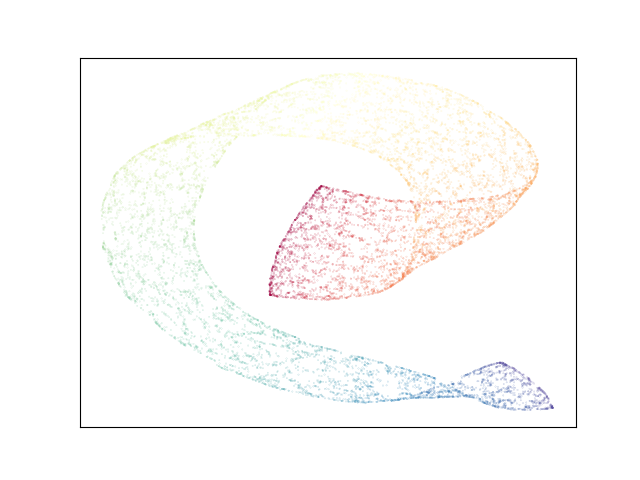

Completed  10000  of  14400


<IPython.core.display.Javascript object>


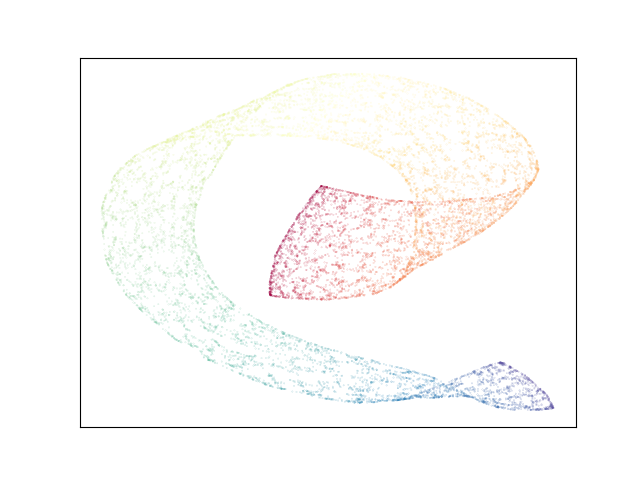

Completed  10000  of  14400


<IPython.core.display.Javascript object>


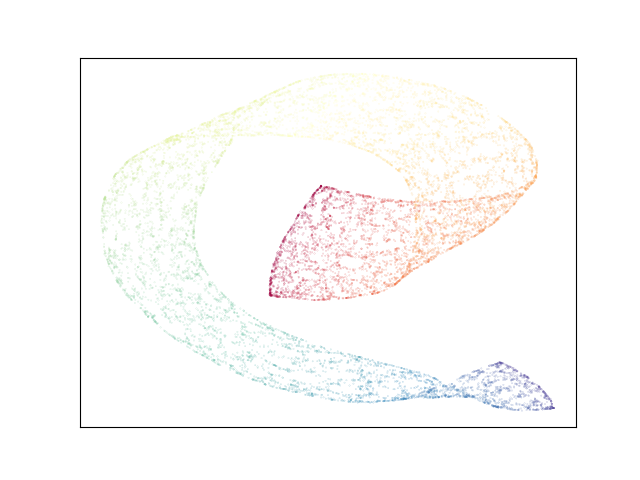

Completed  10000  of  14400


<IPython.core.display.Javascript object>


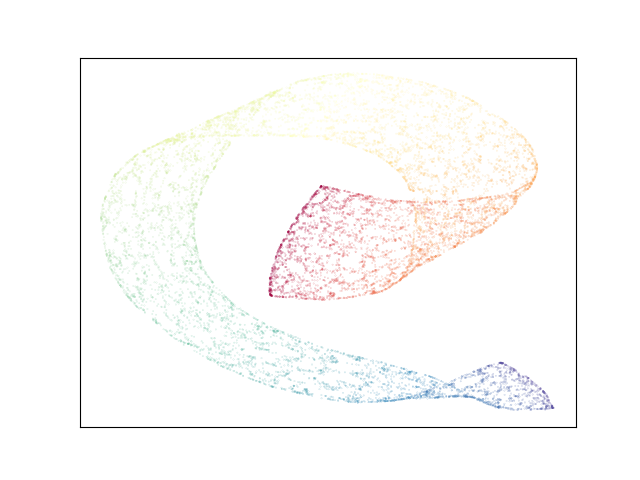

In [47]:
np.random.seed(23423)

rand_perm = np.random.permutation(n)

X_train_rp = X_train[rand_perm]
y_train_rp = y_train[rand_perm]

nA = 3000
nRest = 11400

SETA = X_train_rp[:nA]
y_SETA = y_train_rp[:nA]

SETS = []
y_SETS = []
DATA = []

N_DATA = []

for i in range(5):
    pass
    print('in loop')
    
    setb = X_train_rp[nA+nRest*i:nA+nRest*(i+1)]
    y_setb = y_train_rp[nA+nRest*i:nA+nRest*(i+1)]
    data = np.concatenate((SETA,setb))
    N_DATA.append(data.shape[0])
    
    SETS.append(setb)
    y_SETS.append(y_setb)
    DATA.append(data)

    
print('out of loop')    

SETS = np.array(SETS)
DATA = np.array(DATA)
N_DATA = np.array(N_DATA)

n_SET = SETS.shape[0]

print(SETA.shape, SETS.shape, SETS[0].shape, DATA.shape, n_SET)

with open('SR_Aligned_NE_5_SETS_3000_11400.npy', 'rb') as f:
    embA_5s = np.load(f)
    emB_sets = np.load(f)
    
TRST = np.zeros(len(emB_sets))

    
for i in range(len(emB_sets)):
    emb_set_ns5 = np.concatenate((embA_5s, emB_sets[i]))
    emb_set_ns5 = map_rotate(emb_set_ns5, rot_angle=40)
    y_emb_set_ns5 = np.concatenate((y_SETA, y_SETS[i]))
    
    sort_idx_ns5, _ = get_first_order_graph(DATA[i],n_neighbors=DATA[i].shape[0]-1)
    TRST[i] = my_trustworthiness(emb_set_ns5, sort_idx_ns5, k_nn)

    plt.figure()
    plt.scatter(emb_set_ns5[:,0], -emb_set_ns5[:,1], c=y_emb_set_ns5, s=0.01, cmap='Spectral')
    plt.xticks([],[])
    plt.yticks([],[])

    plt.xlim([-6.80, 6.1])
    plt.ylim([-8.20, 7.4])

    plt.savefig('sr_figures/ne_umap5split_3000_11400_'+str(i)+'.png', dpi=fig.dpi, bbox_inches='tight')
    


    

In [26]:
for i in range(len(emB_sets)):
    print('T', i, ': ', TRST[i])
    
    
total_emb = np.concatenate(emB_sets)
total_emb = np.concatenate((embA_5s, total_emb))

T_5sets = my_trustworthiness(total_emb, sort_idx, 5)

print('Trustworthiness: ', T_5sets)

T 0 :  0.9901353404283244
T 1 :  0.9900761428031005
T 2 :  0.9890117474600086
T 3 :  0.9896336101074671
T 4 :  0.9884189943487123
Trustworthiness:  0.9885086733786728


In [27]:
print('Trustworthiness: ', T_5sets)

Trustworthiness:  0.9885086733786728
